# Иследование сервиса аренды самокатов GoFast

В нашем распоряжении данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. Наша задача: проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти и решить, стоит ли выполнять задачу продакт-менеджерам, которые хотят увеличить количество пользователей с подпиской. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

**Сервисом можно пользоваться:**
1. *Без подписки* 

абонентская плата отсутствует;
стоимость одной минуты поездки —  8 рублей;
стоимость старта (начала поездки) — 50 рублей;

2. *С подпиской Ultra* 

абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки —  6 рублей;
стоимость старта — бесплатно.

**Помимо этого, в нашем распоряжении данные следующие данные:** уникальный идентификатор пользователя; имя пользователя; возраст; город; тип подписки (free, ultra); расстояние, которое пользователь проехал в текущей сессии (в метрах); продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»; дата совершения поездки.

**На основе этих данных мы проведем исследование и построим нашу работу следующим образом:**
1. Загрузим, предобработаем и визуализируем имеющиеся данные.
2. Подсчитаем выручку, которую сервису принес конкретный пользователь в конкретный месяц.
3. На основе результатов, полученных во втором шаге, определим:
а) Какая категория пользователей (с подпиской или без) тратит больше времени на аренду самокатов.
б) Какая категория пользователей (с подпиской или без) проезжает большее расстояние.
в) Какая категория пользователей (с подпиской или без) принесёт больше выручки бизнесу по месяцам.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/Users/egorkuzovcikov/Downloads/users_go.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датафрейме хранится 1565 наблюдений, пропусков не обнаружено – количество наблюдений во всех столбцах одинаковое.

In [3]:
rides = pd.read_csv('/Users/egorkuzovcikov/Downloads/rides_go.csv')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В датафрейме хранится 18068 наблюдений, что значительно больше, чем в датафрейме users. Это не вызывает опасений, так как каждая строка в датафрейме rides показывает отдельную поездку любого пользователя, а каждый из них мог совершать несколько поездок в месяц. Пропусков не обнаружено – количество наблюдений во всех столбцах одинаковое.

In [4]:
sub = pd.read_csv('/Users/egorkuzovcikov/Downloads/subscriptions_go.csv')
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


В датафрейме хранится 2 наблюдения – по количеству доступных вариантов подписки. Пропусков не обнаружено – количество наблюдений во всех столбцах одинаковое.

#### Шаг 2. Предобработка данных

In [5]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d %H:%M')
rides['month'] = rides['date'].dt.month

В датафреймах нет пропущенных значений.

In [6]:
users.duplicated().sum()

31

В датафрейме users обнаружено 31 дубликат. Избавимся от них.

In [7]:
users = users.drop_duplicates()
rides.duplicated().sum()

0

В датафрейме rides не обнаружено дубликатов. 

Формат данных датафреймов не предполагает неявных дубликатов (а в датафрейме sub всего две строчки), поэтому после проверки на явные дубликаты фреймов users и rides удалили явные дубликаты.

#### Шаг 3. Исследовательский анализ данных

**1. Частота встречаемости городов**

In [8]:
cities = users.value_counts('city')
cities

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
dtype: int64

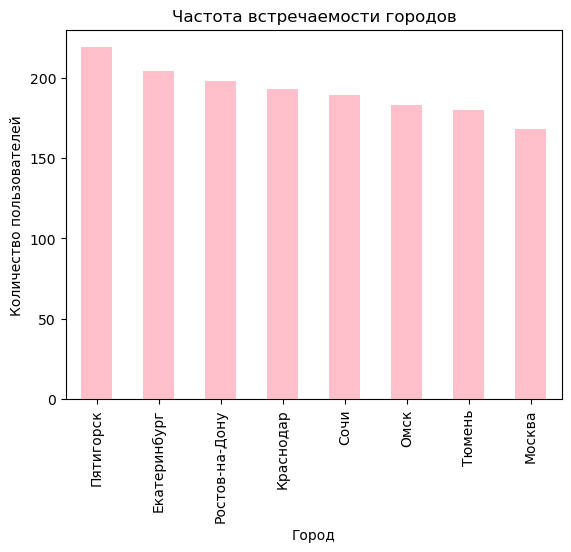

In [9]:
cities.plot(kind='bar', color='pink')
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

Больше всего пользователей в Пятигорске (219), меньше всего в Москве (168).

**2. Соотношение пользователей с подпиской и без подписки**

In [10]:
fee = users.value_counts('subscription_type')
fee

subscription_type
free     835
ultra    699
dtype: int64

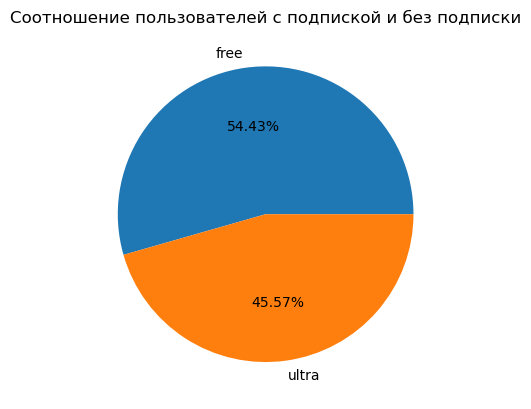

In [11]:
fee.plot(kind='pie', autopct='%1.2f%%')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel(None)
plt.show()

Больше пользователей сервиса не имеют платной подписки (54,43% по сравнению с 45,57% у тех, кто имеет подписку). Без подписки – 835 пользователей, с подпиской – 699.

**3.Возраст пользователей**

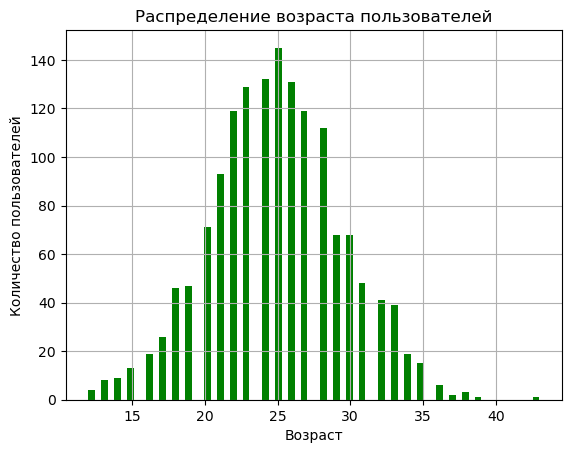

In [12]:
users['age'].hist(bins=70, color='green')
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

In [13]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Преимущественно сервисом пользуются люди от 22 до 28 лет. Средний возраст пользователя -- 25 лет. Пользователей младше 12 и старше 43 не обнаружено.

**4. Расстояние, которое пользователь преодолел за одну поездку**

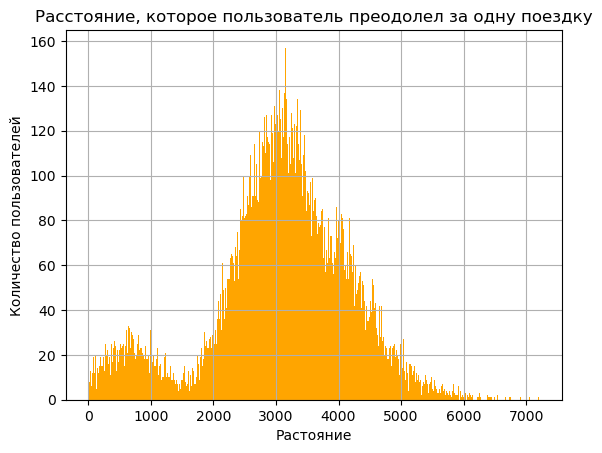

In [14]:
rides['distance'].hist(bins=500, color='orange')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Растояние')
plt.ylabel('Количество пользователей')
plt.show()

Расстояние, преодолеваемое пользователями лежит в интервале от 2500 до 3500 метров. Пользователей, которые преодолевают больше 6000 метров практически не обнаружено. Имеется небольшой выброс на интервале от 0 до 1500 метров.

**5. Продолжительность поездок**

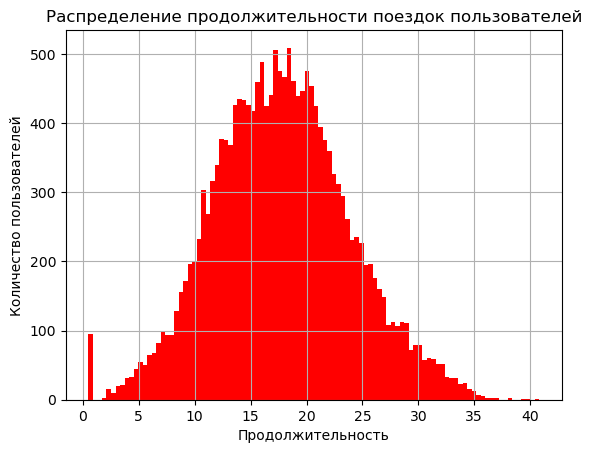

In [15]:
rides['duration'].hist(bins=100, color='red')
plt.title('Распределение продолжительности поездок пользователей')
plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей')
plt.show()

Преимущественно поездки длятся от 5 до 30 минут. Поездок дольше, чем 35 минут практически не найдено.

In [16]:
rides.sort_values('duration')

,user_id,distance,duration,date,month
12013,1102,4602.122401,0.500000,2021-08-01,8
17314,1483,4445.481070,0.500000,2021-03-06,3
15029,1318,5894.633314,0.500000,2021-03-28,3
7437,766,4539.088310,0.500000,2021-12-22,12
12967,1172,4907.140751,0.500000,2021-12-19,12
...,...,...,...,...,...
6453,694,4210.871467,38.265229,2021-03-11,3
1998,216,4831.339954,38.352763,2021-05-11,5
2623,278,4754.433686,39.526602,2021-12-02,12
4709,507,4645.642671,39.873856,2021-01-15,1


Среди значений есть выброс -- около 100 пользователей, которые ехали меньше минуты.

#### Шаг 4. Объединение данных

In [17]:
data_old = users.merge(rides, on='user_id')
data = data_old.merge(sub, on = 'subscription_type')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Количество наблюдений, получившихся в таблице – 18068. Именно столько наблюдений и было в датафрейме rides. Объединение выполнено верно.

In [18]:
data_ultra = data.query('subscription_type == "ultra"')
data_free = data.query('subscription_type == "free"')

data_ultra.head()
data_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


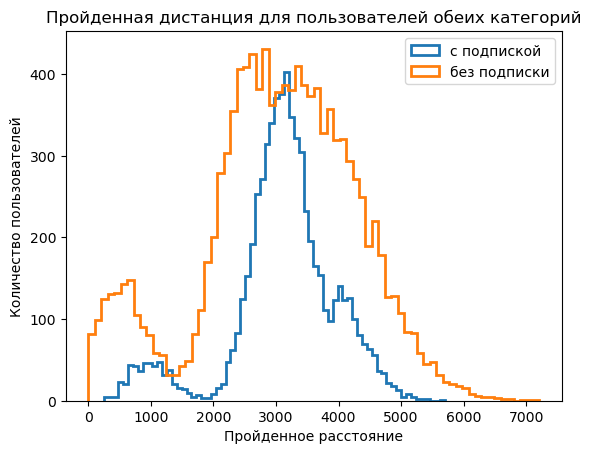

In [19]:
data_ultra['distance'].plot(kind='hist', histtype='step'
                                        , bins=70, label='c подпиской', linewidth=2, legend=True)
data_free['distance'].plot(kind='hist', histtype='step'
                                        , bins=70, label='без подписки', linewidth=2, legend=True)
plt.title('Пройденная дистанция для пользователей обеих категорий')
plt.xlabel('Пройденное расстояние')
plt.ylabel('Количество пользователей')
plt.show()

Средняя дистанция, пройденная пользователями с подпиской и без подписки на первый взгляд распределена примерно одинаково с общими трендами распределения пройденного расстояния (до 800-900 метров – рост, падение до 1500-2000 метров, снова рост на интервале от 1500-2000 до приблизительно 3000 метров и снова падение). Небольшое отличие заметно лишь потому, что пользователей без подписки больше, поэтому графики немного отличаются.

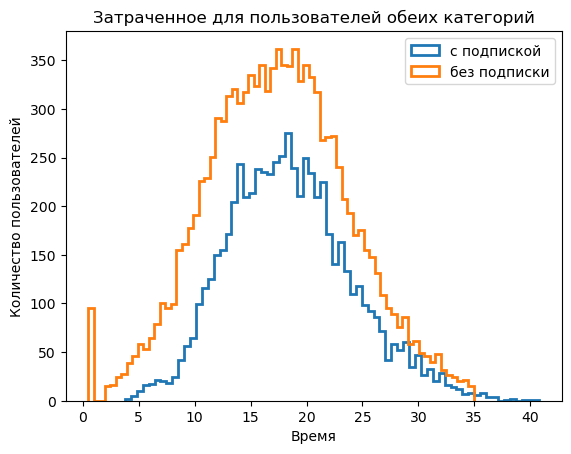

In [20]:
data_ultra['duration'].plot(kind='hist', histtype='step'
                                        , bins=70, label='c подпиской', linewidth=2, legend=True)
data_free['duration'].plot(kind='hist', histtype='step'
                                        , bins=70, label='без подписки', linewidth=2, legend=True)
plt.title('Затраченное для пользователей обеих категорий')
plt.xlabel('Время')
plt.ylabel('Количество пользователей')
plt.show()

Средняя время, затраченное пользователями с подпиской и без подписки на первый взгляд распределено примерно одинаково с общими трендами распределения затраченного времени (постепенный рост на интервале до 20 минут и падение после 20 минут). Небольшое отличие заметно лишь потому, что пользователей без подписки больше, поэтому графики немного отличаются.

#### Шаг 5. Подсчёт выручки

In [21]:
data['duration'] = np.ceil(data['duration']) 
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


In [22]:
pivot_data = pd.pivot_table(data, index=['user_id', 'month'], 
                            values = ['distance', 'name', 
                                      'duration', 'subscription_type', 'start_ride_price', 'subscription_fee', 'minute_price'], 
                            aggfunc={'distance': 'sum', 
                                     'name': 'count',
                                     'duration': 'sum',
                                     'subscription_type': 'first',
                                     'start_ride_price': 'first',
                                     'subscription_fee': 'first',
                                     'minute_price': 'first'}).reset_index()
pivot_data

,user_id,month,distance,duration,minute_price,name,start_ride_price,subscription_fee,subscription_type
0,1,1,7027.511294,42.0,6,2,0,199,ultra
1,1,4,754.159807,7.0,6,1,0,199,ultra
2,1,8,6723.470560,46.0,6,2,0,199,ultra
3,1,10,5809.911100,32.0,6,2,0,199,ultra
4,1,11,7003.499363,56.0,6,3,0,199,ultra
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,8,2,50,0,free
11327,1534,8,7622.453034,48.0,8,2,50,0,free
11328,1534,9,4928.173852,23.0,8,1,50,0,free
11329,1534,11,13350.015305,78.0,8,4,50,0,free


In [23]:
pivot_data['revenue'] = ((pivot_data['name']*pivot_data['start_ride_price']) + (pivot_data['duration']*pivot_data['minute_price']) + pivot_data['subscription_fee'])
pivot_data

,user_id,month,distance,duration,minute_price,name,start_ride_price,subscription_fee,subscription_type,revenue
0,1,1,7027.511294,42.0,6,2,0,199,ultra,451.0
1,1,4,754.159807,7.0,6,1,0,199,ultra,241.0
2,1,8,6723.470560,46.0,6,2,0,199,ultra,475.0
3,1,10,5809.911100,32.0,6,2,0,199,ultra,391.0
4,1,11,7003.499363,56.0,6,3,0,199,ultra,535.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,8,2,50,0,free,308.0
11327,1534,8,7622.453034,48.0,8,2,50,0,free,484.0
11328,1534,9,4928.173852,23.0,8,1,50,0,free,234.0
11329,1534,11,13350.015305,78.0,8,4,50,0,free,824.0


#### Шаг 6. Проверка гипотез

**1. H0: пользователи с подпиской тратят столько же времени времени на поездки, как и пользователи без подписки**

**H1: пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки**

In [24]:
alpha = 0.05

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

print('p-значение:', results.pvalue) # добавьте в аргумент p-value

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


По результатам тестирования гипотезы мы можем прийти к выводу, что с большей вероятностью **пользователи с подпиской тратят больше времени на поездки** по сравнению с пользователями без подписки.

**2. H0 = поездки как пользователей без подписки, так и пользователей с подпиской равны 3130 метра**

**Н1 = расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров**

In [25]:
interested_value = 3130

alpha = 0.05

results = st.ttest_1samp(
    data_ultra['distance'], 
    interested_value,
      alternative='less')

print('p-значение:', results.pvalue) # добавьте в аргумент p-value

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: поездка в среднем значимо меньше 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу: поездки в среднем достигают запланированных показателей')

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу: поездки в среднем достигают запланированных показателей


Расстояние, которое проезжают пользователи с подпиской за одну поездку, достигает запланированных показателей и не превышает 3130 метров.

**3. H0: средние значения трат пользователей из двух групп (пользователи с подпиской и без подписки) равны.**

**H1: среднее значение трат пользователей с подпиской больше, чем среднее значение трат пользователей без подписки**

In [26]:
ultra = pivot_data.query('subscription_type == "ultra"')
free = pivot_data.query('subscription_type == "free"')

In [27]:
alpha = 0.05

results = st.ttest_ind(ultra['revenue'], free['revenue'], alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


По результатам тестирования гипотезы мы можем прийти к выводу, что среднее значение трат пользователей с подпиской больше, чем среднее значение трат пользователей без подписки, следовательно, пользователи с подпиской приносят больше прибыли, чем пользователи без подписки.

Tехническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Здесь нужно было бы применять гипотезу о равенстве средних для зависимых (парных) выборок и применить метод scipy.stats.ttest_rel().

# Общие выводы

В данном исследовании мы проанализировали данные и проверили некоторые гипотезы, которые могут помочь бизнесу вырасти и решить, стоит ли выполнять задачу продакт-менеджерам по увеличению количества пользователей с подпиской.

Основываясь на данных полученных из трёх датасетов (users_go, rides_go, subscriptions_go), содержащих детальную информацию о каждой поездке каждого пользователя, мы избавились от неточностях в данных (удалили дубликаты в датафрейме users), мы предприняли следующие шаги:

1. Провели исследовательский анализ данных, чтобы определить частота встречаемости городов, соотношение пользователей с подпиской и без подписки, возраст пользователей, расстояние, которое пользователь преодолел за одну поездку, продолжительность поездок.
2. Определили среднюю пройденную дистанцию и затраченное время по двум категориям — пользователи без подписки и пользователи с подпиской.
3. Подсчитали выручку, которую приносит каждый пользователь за отдельно взятый месяц.
4. Вывели гипотезы и протестировали их, чтобы ответить на следующие поставленные вопросы:
а) тратят ли пользователи с подпиской больше времени на поездки?
б) можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
в) будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Проанализировав данные о пользователях сервиса аренды самокатов GoFast и их поездках, можно сделать следующие выводы:

1. Больше всего пользователей сервиса в Пятигорске (219), меньше всего в Москве (168).
2. Больше половины пользователей (54,43%) сервиса не имеют платной подписки. Платная подписки есть лишь у 45,57% пользователей.
3. Преимущественно сервисом пользуются люди от 22 до 28 лет. Пользователей младше 12 и старше 43 не обнаружено.
4. Расстояние, преодолеваемое пользователями лежит в интервале от 2500 до 3500 метров. Пользователей, которые преодолевают больше 6000 метров практически не обнаружено. Имеется небольшой выброс на интервале от 0 до 1500 метров.
5. Преимущественно поездки длятся от 5 до 30 минут. Поездок дольше, чем 35 минут практически не найдено.
6. Пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки.
7. Расстояние, которое проезжают пользователи с подпиской за одну поездку, достигает запланированных показателей и не превышает 3130 метров.
8. Среднее значение трат пользователей с подпиской больше, чем среднее значение трат пользователей без подписки, следовательно, пользователи с подпиской приносят больше прибыли, чем пользователи без подписки.

Суммируя все вышесказанное, мы можем прийти к итоговому выводу, что пользователи с подпиской приносят больше прибыли для сервиса GoFast, поэтому задача по увеличению количества пользователей с подпиской, поставленная продакт-менеджерами, вполне обоснованная и релевантная.